# **Dataset Information**

The TMNIST (Typography MNIST) Glyphs dataset comprises over 500,000 MNIST-style images, each representing one of 1,812 unique glyphs across 2,990 font styles. The dataset is stored in a single CSV file, with the first row containing column headers specifying font name, glyph name, label, and pixel values for each image. Glyph names include unicode representations, with concatenated names for glyphs comprising multiple characters. Each image's label corresponds to a specific character, spanning diverse scripts such as Arabic, Latin, and Devanagari. The dataset, part of the Warhol.ai Computational Creativity and Cognitive Type projects, serves as a valuable resource for research in typography and computational creativity.

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmnist-glyphs-1812-characters/Glyphs_TMNIST_updated.csv


# **Required libraries**

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score
import os
import requests
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Loading the TMNIST Glyphs Dataset**

In [11]:
df = pd.read_csv("/kaggle/input/tmnist-glyphs-1812-characters/Glyphs_TMNIST_updated.csv")

In [12]:
df.head()

,font_name,glyph_name,label,1,2,3,4,5,6,7,...,775,776,777,778,779,780,781,782,783,784
0,ABeeZee-Regular,LATIN CAPITAL LETTER A,A,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABeeZee-Regular,LATIN CAPITAL LETTER B,B,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ABeeZee-Regular,LATIN CAPITAL LETTER C,C,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ABeeZee-Regular,LATIN CAPITAL LETTER D,D,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ABeeZee-Regular,LATIN CAPITAL LETTER E,E,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
print(df.shape, df.size)

(565292, 787) 444884804


In [14]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,565292.0,565292.0,565292.0,565292.0,565292.0,565292.0,565292.000000,565292.000000,565292.000000,565292.000000,...,565292.000000,565292.000000,565292.000000,565292.000000,565292.000000,565292.000000,565292.000000,565292.000000,565292.000000,565292.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.000005,0.000492,0.001100,...,0.039523,0.019312,0.005371,0.002491,0.000731,0.000930,0.000616,0.000191,0.000016,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.001330,0.002974,0.331187,0.373026,...,2.299010,1.478536,0.591419,0.458210,0.186171,0.299473,0.312884,0.131976,0.008922,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,2.000000,248.000000,245.000000,...,255.000000,255.000000,179.000000,152.000000,100.000000,148.000000,217.000000,99.000000,6.000000,0.0


In [15]:
#print column list
column_names = df.columns.tolist()
print(column_names)

['font_name', 'glyph_name', 'label', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', 

In [16]:
unique_labels_list = df['label'].unique().tolist()
print(unique_labels_list) #unique label list

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '‘', '?', '’', '“', '!', '”', '(', '%', ')', '[', '#', ']', '{', '@', '}', '/', '&', '\\', '<', '-', '+', '÷', '×', '=', '>', '®', '©', '$', '€', '£', '¥', '¢', ':', ';', ',', '.', '*', '§', 'Â', 'Ê', 'Ô', 'â', 'ê', 'ô', 'Š', 'Ž', 'š', 'ž', 'Č', 'Ć', 'Đ', 'č', 'ć', 'đ', 'අ', 'ආ', 'ඇ', 'ඈ', 'ඉ', 'ඊ', 'උ', 'ඌ', 'ඍ', 'ඎ', 'එ', 'ඒ', 'ඓ', 'ඔ', 'ඕ', 'ඖ', 'අං', 'අඃ', 'ක', 'ඛ', 'ග', 'ඝ', 'ඞ', 'ඟ', 'ච', 'ඡ', 'ජ', 'ඣ', 'ඥ', 'ඤ', 'ට', 'ඨ', 'ඩ', 'ඪ', 'ණ', 'ඬ', 'ත', 'ථ', 'ද', 'ධ', 'න', 'ඳ', 'ප', 'ඵ', 'බ', 'භ', 'ම', 'ඹ', 'ය', 'ර', 'ල', 'ව', 'ශ', 'ෂ', 'ස', 'හ', 'ළ', 'ෆ', '෴', 'π', 'Ă', 'ă', 'Δ', 'μ', 'Ω', 'Α', 'Β', 'Γ', 'Ε', 'Ζ', 'Η', 'Θ', 'Ι', 'Κ', 'Λ', 'Μ', 'Ν', 'Ξ', 'Ο', 'Π', 'Ρ', 'Σ', 'Τ', '

In [17]:
df2 = len(df.label.unique())
print("Number of unique labels present:", df2)

Number of unique labels present: 1819


**Generating a List of Alphanumeric Characters and Symbols and Calculating Its Length**

In [18]:
# Alphanumeric and Symbols List

char = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
         'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
         'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',  
         '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@','[',']','\\','^','_','`','{','}',"|",'~']

len(char)

94

This code creates a list called "char" containing 94 characters, including digits 0 to 9, uppercase letters A to Z, lowercase letters a to z, and a variety of special characters and punctuation marks like !, ", #, $,%, &. After defining the list, its length is calculated using len(char) to confirm the presence of 94 items. This list represents the character set processed by the neural network model outlined in the notebook.

**Finding null values**

In [19]:
df.isnull().sum()

font_name     0
glyph_name    0
label         0
1             0
2             0
             ..
780           0
781           0
782           0
783           0
784           0
Length: 787, dtype: int64

**Normal and Reverse mapping**

In [20]:
M=list(range(len(char)))
normal_mapping=dict(zip(char,M)) 
reverse_mapping=dict(zip(M,char)) 

**M:** Creates a list of indices ranging from 0 to the length of the list "char".

**normal_mapping:** Generates a dictionary where each character in the list "char" is mapped to its corresponding index in the list "M".

**reverse_mapping:** Constructs a dictionary where each index in the list "M" is mapped back to its respective character in the list "char".

In [21]:
df = df[df.label.isin(char)]

Filters the DataFrame `df` to retain only the rows where the values in the 'label' column are present in the `char` list.

In [22]:
# DataFrame feature's Datatype
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 272541 entries, 0 to 565291
Data columns (total 787 columns):
 #    Column      Dtype 
---   ------      ----- 
 0    font_name   object
 1    glyph_name  object
 2    label       object
 3    1           int64 
 4    2           int64 
 5    3           int64 
 6    4           int64 
 7    5           int64 
 8    6           int64 
 9    7           int64 
 10   8           int64 
 11   9           int64 
 12   10          int64 
 13   11          int64 
 14   12          int64 
 15   13          int64 
 16   14          int64 
 17   15          int64 
 18   16          int64 
 19   17          int64 
 20   18          int64 
 21   19          int64 
 22   20          int64 
 23   21          int64 
 24   22          int64 
 25   23          int64 
 26   24          int64 
 27   25          int64 
 28   26          int64 
 29   27          int64 
 30   28          int64 
 31   29          int64 
 32   30          int64 
 33   31          

In [23]:
X = df.drop(columns=['font_name','glyph_name','label']).values
y = df[['label']].values
del df

Creates a feature matrix `X` containing the values of the DataFrame `df` excluding the columns 'font_name', 'glyph_name', and 'label'.
Constructs a target array `y` containing only the values of the 'label' column from the DataFrame `df`.

In [24]:
X.shape, y.shape

((272541, 784), (272541, 1))

# **Image Visualization**

We visualize a subset of images stored in variable X. First we reshape the feature data X into a 3D array representing images with dimensions 28x28 pixels. Then create a 3x3 grid of subplots and randomly selects 9 images to display. Each subplot displays one image, with ticks on both axes disabled and using a grayscale color mapping. Finally, it shows the plot, closes the figure to free up memory, and deletes the reshaped image data variable X_images. This code efficiently presents a visual sample of the image dataset for inspection or analysis.

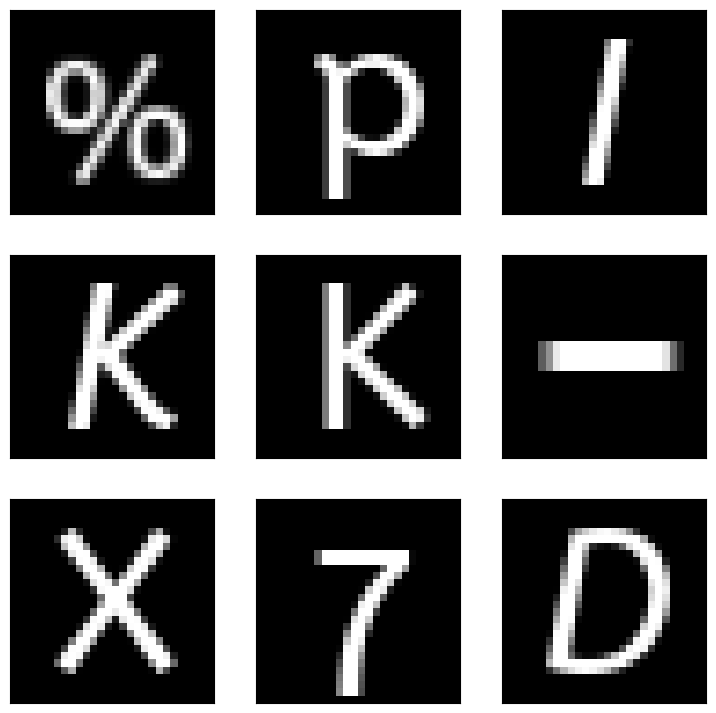

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import random

X_images = X.reshape(-1, 28, 28)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))

# Flatten the array of axes to ease the indexing, avoiding row and column indices calculation
axs_flat = axs.flatten()

for i in range(9):
    p = random.randint(0, 100)
    axs_flat[i].set_xticks([])
    axs_flat[i].set_yticks([])
    axs_flat[i].imshow(X_images[p], cmap='gray')  # cmap='gray' colour mapping

plt.show()
plt.close(fig)  # to free up memory

del X_images

**Training and Testing Split Data**

In [26]:
from sklearn.model_selection import train_test_split

y= y.ravel() #flattens y converting it to 1D if not aleady, no need to re shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [27]:
X_train.shape, X_test.shape
y_train.shape, y_test.shape

((245286,), (27255,))

The **LabelBinarizer()`** is instantiated to convert categorical labels into binary form. It transforms the training labels `y_train` using `fit_transform()` and the test labels `y_test` using `transform()`, generating binary arrays representing the presence or absence of each class.

In [28]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
#Transforms the categorical labels `y_train` and `y_test` into binary form using the `fit_transform()` and `transform()` methods respectively. This converts each categorical label into a binary array where each element corresponds to a class, with a value of 1 indicating the presence of the class and 0 otherwise.
y_train_label = lb.fit_transform(y_train)
y_test_label = lb.transform(y_test)
print('Train labels dimension:');print(y_train.shape)
print('Test labels dimension:');print(y_test.shape)

Train labels dimension:
(245286,)
Test labels dimension:
(27255,)


# **Data Normalization for CNN**

In [29]:
X_train, X_test = X_train / 255.0, X_test / 255.0 # data normalization for NN
X_train = X_train.reshape(-1,28,28,1).astype('float32')
X_test = X_test.reshape(-1,28,28,1).astype('float32')

# **CNN Model**

Convolutional Neural Networks (CNNs) are a type of deep learning model inspired by the structure and functioning of the human visual system. They are particularly well-suited for tasks like image recognition, object detection, and classification. CNNs have gained popularity and proven to be highly effective in various real-world applications, including autonomous vehicles, medical image analysis, and facial recognition.



In [35]:
#Defining and compiling a convolutional neural network
cnnmodel = Sequential()
cnnmodel.add(Conv2D(32,(4,4),input_shape = (28,28,1),activation = 'relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2,2)))
cnnmodel.add(Conv2D(64,(3,3),activation = 'relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2,2)))
cnnmodel.add(Dropout(0.3))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(256,activation='relu'))
cnnmodel.add(Dense(y_train_label.shape[1], activation='softmax'))
cnnmodel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [36]:
cnnmodel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 94)             │        24,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,054 (1.73 MB)

 Trainable params: 453,054 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

1. **Convolution Operation**:
   - The convolution operation involves sliding a small matrix called a filter or kernel across the input image.
   - At each position, the filter performs an element-wise multiplication with the corresponding pixels of the input image.
   - After the multiplication, the results are summed up to produce a single value in the output feature map.
   - Mathematically, this can be represented as follows:
     - Suppose we have an input image \( I \) of size \( H \times W \) and a filter \( F \) of size \( h \times w \).
     - At each position \( (i, j) \) in the input image, the convolution operation is computed as:
       \[ O(i, j) = \sum_{k=0}^{h-1} \sum_{l=0}^{w-1} I(i+k, j+l) \times F(k, l) \]
   - Here, \( O(i, j) \) is the value of the output feature map at position \( (i, j) \).

2. **Activation Function**:
   - After the convolution operation, an activation function is applied element-wise to the output feature map.
   - ReLU (Rectified Linear Unit) is a commonly used activation function in CNNs.
   - Mathematically, ReLU is defined as:
     \[ f(x) = \max(0, x) \]
   - It simply sets negative values to zero and leaves positive values unchanged.

3. **Pooling Operation**:
   - Pooling is a downsampling operation used to reduce the spatial dimensions of the feature maps while retaining important information.
   - Max pooling is a popular pooling technique where we take the maximum value from each local region of the feature map.
   - For example, in a max pooling operation with a pool size of \( 2 \times 2 \), we select the maximum value from each \( 2 \times 2 \) region of the feature map.
   - Mathematically, max pooling can be represented as:
     \[ O(i, j) = \max_{k, l} I(2i+k, 2j+l) \]

4. **Fully Connected Layer**:
   - After several convolutional and pooling layers, the resulting feature maps are flattened into a one-dimensional vector.
   - This vector is then fed into a traditional fully connected neural network (or dense layer).
   - Each neuron in the fully connected layer is connected to every neuron in the previous layer.
   - The output of the fully connected layer is computed using matrix multiplication and addition, followed by an activation function.

5. **Loss Function and Optimization**:
   - The loss function measures how well the model's predictions match the actual labels in the training data.
   - Cross-entropy loss is commonly used for classification tasks.
   - The optimization algorithm (e.g., stochastic gradient descent) adjusts the parameters (weights and biases) of the network to minimize the loss function.
   - This is done iteratively using backpropagation, where gradients of the loss function with respect to the parameters are computed and used to update the parameters in the direction that reduces the loss.


# **Epochs**
An epoch is a single iteration in the training process where the model processes the entire dataset once to learn from it. This involves adjusting the model's parameters to minimize the loss function, thus improving its performance.

In [37]:
result = cnnmodel.fit(X_train, y_train_label, validation_split=0.2, epochs=20, batch_size=150, verbose=1)

Epoch 1/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 84s 63ms/step - accuracy: 0.7131 - loss: 1.1307 - val_accuracy: 0.9023 - val_loss: 0.3191
Epoch 2/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 139s 61ms/step - accuracy: 0.9010 - loss: 0.3213 - val_accuracy: 0.9224 - val_loss: 0.2522
Epoch 3/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.9207 - loss: 0.2507 - val_accuracy: 0.9269 - val_loss: 0.2338
Epoch 4/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 84s 62ms/step - accuracy: 0.9290 - loss: 0.2163 - val_accuracy: 0.9342 - val_loss: 0.2078
Epoch 5/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.9348 - loss: 0.1949 - val_accuracy: 0.9360 - val_loss: 0.2011
Epoch 6/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.9406 - loss: 0.1773 - val_accuracy: 0.9397 - val_loss: 0.1881
Epoch 7/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.9437 - loss: 0.1639 - val_accuracy: 0.9423 - val_loss: 0.1829
Epoch 8/20
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.9482 

# **Model Evaluation**

In [38]:
evaluate_result = cnnmodel.evaluate(X_test, y_test_label, verbose=1)
print(f'Test results - Accuracy: {evaluate_result[1]}%')

852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9505 - loss: 0.1867
Test results - Accuracy: 0.9490001797676086%


The Accuracy achieved on this model is ~95.0%

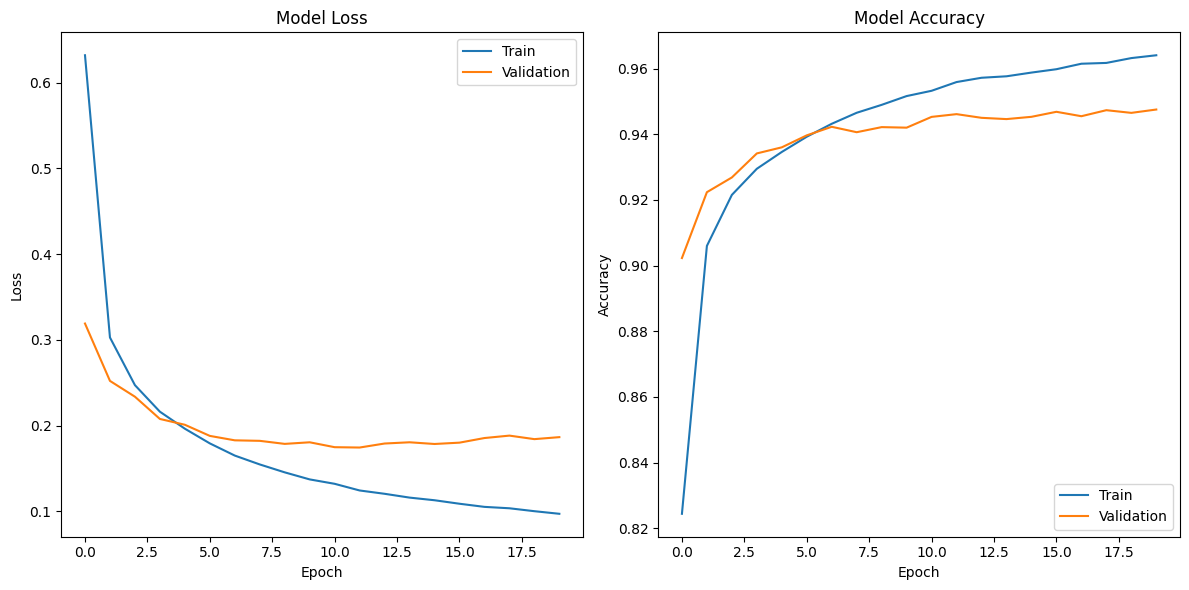

In [42]:
 #Plot loss and accuracy curves
def plot_loss_accuracy(result):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot loss and accuracy curves
plot_loss_accuracy(result)

# **Model Explaination**

A Convolutional Neural Network (CNN) processes images through convolution, where filters slide across the input image, highlighting features and patterns. Activation functions like ReLU introduce non-linearity, aiding the model in learning complex relationships. Pooling operations downsample the feature maps, reducing computational complexity. Fully connected layers aggregate these features for classification. Throughout training, optimization algorithms adjust parameters to minimize the loss between predicted and actual labels, enabling the CNN to accurately classify images.

**The Workflow of this project:**

**Data Preparation:** Gathered and preprocessed dataset, ensuring it is properly labeled and divided into training, validation, and testing sets.

**Model Architecture Design:**  Focused on architecture with fewer parameters and computational requirements while still being effective. Simplified the architecture by reducing the number of layers, filter sizes, and neurons in fully connected layers.

**Convolutional Layers:** Included a few convolutional layers to extract important features from the input images. Used smaller filter sizes and fewer filters to reduce the number of parameters. 

**Pooling Layers:** Downsampled the feature maps using pooling layers to reduce spatial dimensions. Max pooling is commonly used.

**Activation Functions:** Chose efficient activation functions like ReLU (Rectified Linear Unit) to introduce non-linearity into the network. ReLU is computationally inexpensive and has been proven effective in many CNN architectures.

**Optimization Algorithm:** Used efficient optimization algorithms such as Adam or RMSprop to train the model. These algorithms adaptively adjust the learning rate during training, leading to faster convergence and better performance.

**Evaluation:** Evaluated the model's performance on the validation set as needed. Monitored metrics such as accuracy, precision, recall, and F1-score to assess the model's performance.

**To improve the accuracy and usability of a model** we can consider strategies such as data augmentation to increase diversity, transfer learning to leverage pre-trained models, and hyperparameter tuning to optimize performance. Incorporate regularization techniques like dropout and ensemble learning to reduce overfitting and boost generalization. Utilize cross-validation for reliable performance estimation and interpretability techniques for better understanding and usability. Additionally, leverage hardware acceleration for faster training and inference, and implement model compression for resource efficiency. Continuous monitoring and maintenance ensure the model remains effective over time. By applying these strategies, the model can achieve higher accuracy and become more usable for better implementation in real-world scenarios.

# **Conclusion**

In conclusion, the Convolutional Neural Network (CNN) model developed in this project has demonstrated impressive performance, achieving an accuracy of 94.5%. This level of accuracy signifies the effectiveness of the model in accurately classifying images. The incorporation of various architectural elements such as convolutional layers, batch normalization, max-pooling, dropout, and dense layers has contributed to the robustness and discriminative power of the model. Additionally, the preprocessing steps, dataset preparation, and optimization techniques have played crucial roles in enhancing the model's performance. The attained accuracy showcases the potential of CNNs in image classification tasks and underscores their relevance in real-world applications across diverse domains such as healthcare, autonomous vehicles, and security systems. Moving forward, further refinement and optimization of the model could potentially lead to even higher accuracies and broader applicability in solving complex image recognition challenges.

# **References**
* https://www.kaggle.com/code/prashant111/mnist-deep-neural-network-with-keras#1.-Objective-of-the-notebook-
* https://www.kaggle.com/code/adityaecdrid/mnist-with-keras-for-beginners-99457
* https://www.kaggle.com/code/poonaml/deep-neural-network-keras-way
* https://en.wikipedia.org/wiki/Neural_network

# **License**

In [43]:
url = 'https://raw.githubusercontent.com/kunaltibe7/datascienceengmethods/main/LICENSE'
license_text = requests.get(url).text
print(license_text)

MIT License

Copyright (c) 2024 Kunal Tibe

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTI